In [1]:
import os
import sys
import pandas as pd
import seaborn as sns
import pandas as pd
import ta
import matplotlib.dates as mdates
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn import svm
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.svm import SVR
from sklearn.metrics import explained_variance_score, r2_score, mean_squared_error 
from ta import add_all_ta_features

nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from src.visualization.visualize import DisplayTicker
from src.features.build_features import StockTechnicals
from src.models.backtest_strategy import TradeHoldStrategy


# Convert Data Function

The function below will load a CSV file with a start and end date to filter out the time range for testing. 

In addition, for feature selection, I used the following subset features for regression, there were over 85s features in the TA library:

data_df['SMA_20'] = indicator_SMA20.sma_indicator()

data_df['bb_bbm'] = indicator_bb.bollinger_mavg()

data_df['bb_bbh'] = indicator_bb.bollinger_hband()

data_df['bb_bbl'] = indicator_bb.bollinger_lband()

data_df['MACD'] = indicator_MACD.macd()

data_df['MACD signal'] = indicator_MACD.macd_signal()


In [2]:
def convert_data(stock_ticker_csv, start_date, end_date):
    """
    stock_ticker_csv : csv file
    end_date : string
    days_to_backtrack : int
    Takes in a CSV File and converts the date to numbers
    Returns DF with Dates converted to numerical format and the original Dates for plotting
    """

    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')
 

    # Load the CSV File
    stock_ticker = pd.read_csv(stock_ticker_csv, index_col=['Date'], parse_dates=['Date'])
    stock_ticker.sort_values('Date')
    stock_ticker = stock_ticker[start_date: end_date]

    stock_ticker.reset_index(inplace=True)
    
    data_df = stock_ticker.copy()
    data_df = data_df.reset_index()
    org_dates = data_df['Date']
    data_df['Pretty Date'] = data_df['Date']
    

    # Converting Dates to Numbers - SVR doesn't work with dates
    data_df['Date'] = data_df['Date'].map(mdates.date2num)

    indicator_bb = ta.volatility.BollingerBands(close=data_df["Close"], n=20, ndev=2)
    indicator_SMA20 = ta.trend.SMAIndicator(close=data_df["Close"],n=20, fillna=True)
    indicator_MACD = ta.trend.MACD(close=data_df["Close"],n_fast=5, n_slow=30, fillna=True)
  
    # Features added to original date
    data_df['SMA_20'] = indicator_SMA20.sma_indicator()
    data_df['bb_bbm'] = indicator_bb.bollinger_mavg()
    data_df['bb_bbh'] = indicator_bb.bollinger_hband()
    data_df['bb_bbl'] = indicator_bb.bollinger_lband()
    data_df['MACD'] = indicator_MACD.macd()
    data_df['MACD signal'] = indicator_MACD.macd_signal()
 
    # Return DF with Dates converted to numerical format and the original Dates for plotting
    return data_df, org_dates




In [3]:
# This function was used to do a GridSearch for SVR. I was originally using it to calculate the best parameters if no specific features were provided.

def svc_param_selection(X, y, nfolds, model):
    Cs = [10, 100, 1000, 10000, 100000]
    gammas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVR(kernel=model), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_

    return grid_search.best_params_

# Model Training and Prediction Function

This function takes the ticker dataframe, forecasted number of dates (5 in this case), and tries to predict a price based on the probided parameters. If no parameters are provided, it will leverage the Grid search parameters.

In [4]:
def predict_multiple_variables(ticker_df, dates_org, num_forecast_days, C_user=None, G_user=None, model =  'rbf'):

    #features=['Date','SMA_20','Open','Volume', 'bb_bbl', 'MACD']
    features=['Date','SMA_20','Open', 'bb_bbl']
    num_training_days = len(ticker_df)
    days_to_predict = dates_org[-num_forecast_days:].dt.date
    print("=" * 100)
    print("Predicting values for the following dates: ")
    for d in days_to_predict:
        print(f'{d}')
    print("=" * 100)
    #print(f'{type(dates_org[-num_forecast_days:])}')
    #print(f'{type(dates_org[-num_forecast_days:].values)}')
    
    #print(dates_org[-num_forecast_days:])
    train_x = ticker_df[-(num_training_days+num_forecast_days):-num_forecast_days][features]
    # Seperate Predicted variable
    train_y = ticker_df[-(num_training_days+num_forecast_days):-num_forecast_days][['Adj Close']]

     # Split off test days for forecasting
    test_x = ticker_df[-num_forecast_days:][features]
    test_y = ticker_df[-num_forecast_days:][['Adj Close']]
    
    #  Grid Search gets extremely slow for any models beyond rbf
    best_params = svc_param_selection(train_x, train_y.values.reshape(-1,), 3, model=model)
    
    if C_user is None or G_user is None:
        C_user = best_params["C"]
        G_user = best_params["gamma"]
        #C_user = 1000
        #G_user = 0.008
        print(f'Using Grid Search Values C {C_user} and gamma {G_user} values')
        #print(f'Using Default values C {C_user} and gamma {G_user} values')
    else:
        print(f'Using user provided C {C_user} and gamma {G_user} values')
    
    # Fit training data using SVR/RBF
    svr_rbf = SVR(kernel= model, C=C_user, gamma= G_user)
    
    svr_rbf.fit(train_x, train_y.values.reshape(-1,))

    
    
    y_pred = svr_rbf.predict(test_x)
    print("=" * 90)
    print("Predicted Values: {}".format(y_pred))
    print("-" * 90)
    print(f"Actual Values: {np.squeeze(test_y.values)}")
    print("-" * 90)
    print(f"Model Score: {svr_rbf.score(train_x, train_y)}")
    print("-" * 90)
    print(f"Model R2 Score: {r2_score(test_y, y_pred)}")
    print("-" * 90)
    print(f"Mean Squared Error (MSE): {mean_squared_error(test_y, y_pred)}")
    print("-" * 90)
    print(f"RMSE: {np.sqrt(mean_squared_error(test_y, y_pred))}")
    print("=" * 90)

    plt.figure(figsize = (12,6))
    plt.plot(ticker_df['Pretty Date'][-(num_training_days+num_forecast_days):-num_forecast_days], 
                        svr_rbf.predict(train_x), 
                        color= 'red', label= 'Train Data')

    plt.plot(ticker_df['Pretty Date'][-(num_training_days+num_forecast_days):-num_forecast_days], 
                        train_y , 
                        color= 'black', 
                        label= 'Actual Data')
    plt.legend()
    plt.show()

    plt.figure(figsize = (12,6))

    ax = plt.gca()
    formatter = mdates.DateFormatter("%Y-%m-%d")
    ax.xaxis.set_major_formatter(formatter)
    locator = mdates.DayLocator()
    ax.xaxis.set_major_locator(locator)
    
    #print("xmin: {}".format(num_forecast_days:num_forecast_days+1 ))
    # if the forecast is one day, it will not plot a line

    if num_forecast_days == 1:
        plt.xlim(xmin=ticker_df['Pretty Date'][-num_forecast_days:], xmax=ticker_df['Pretty Date'][-1:])
        plt.scatter(ticker_df['Pretty Date'][-num_forecast_days:], svr_rbf.predict(test_x), 
                        color= 'green', 
                        label= 'Predicted Data')
        plt.scatter(ticker_df['Pretty Date'][-num_forecast_days:], test_y, 
                        color= 'black', 
                        label= 'Actual')

    # Otherwise, plot a line for x > 1
    
    else:
        plt.xlim(xmin=ticker_df['Pretty Date'][-num_forecast_days:-num_forecast_days+1], xmax=ticker_df['Pretty Date'][-1:])
        plt.plot(ticker_df['Pretty Date'][-num_forecast_days:], svr_rbf.predict(test_x), 
                        color= 'green', 
                        label= 'Predicted Data')
        plt.plot(ticker_df['Pretty Date'][-num_forecast_days:], test_y, 
                        color= 'black', 
                        label= 'Actual')
    
    #print("X max: {}, X Min: {}".format(xmax, xmin))
    plt.legend()
    plt.show()

    



In [5]:
def predict_using_random_forest(ticker_df, dates_org, num_forecast_days, estimators_user=1000, criterion_user='mse', state = 1, n_jobs= -1, max_depth=3):

    #features=['Date','SMA_20','Open','Volume', 'bb_bbl', 'MACD']
    features=['Date','SMA_20','Open', 'bb_bbl']
    num_training_days = len(ticker_df)
    days_to_predict = dates_org[-num_forecast_days:].dt.date
    print("=" * 100)
    print("Predicting values for the following dates: ")
    for d in days_to_predict:
        print(f'{d}')
    print("=" * 100)

    train_x = ticker_df[-(num_training_days+num_forecast_days):-num_forecast_days][features]
    # Seperate Predicted variable
    train_y = ticker_df[-(num_training_days+num_forecast_days):-num_forecast_days][['Adj Close']]

     # Split off test days for forecasting
    test_x = ticker_df[-num_forecast_days:][features]
    test_y = ticker_df[-num_forecast_days:][['Adj Close']]    

    # Fit training data using SVR/RBF
    #svr_rbf = SVR(kernel= model, C=C_user, gamma= G_user)
    rand_forest = RandomForestRegressor(n_estimators=estimators_user, criterion=criterion_user, random_state=state, n_jobs=n_jobs, max_depth=max_depth)
    #svr_rbf.fit(train_x, train_y.values.reshape(-1,))

    rand_forest.fit(train_x, train_y.values.reshape(-1,))
    y_train_pred = rand_forest.predict(train_x)

    y_pred = rand_forest.predict(test_x)
    print("=" * 90)
    print("Test Data Predicted Values: {}".format(y_pred))
    print("-" * 90)
    print(f"Actual Values: {np.squeeze(test_y.values)}")
    print("-" * 90)
    print(f"Train Model Score: {rand_forest.score(train_x, y_train_pred)}")
    print("-" * 90)
    print(f"Test Model Score: {rand_forest.score(test_x, y_pred)}")
    print("-" * 90)
    print(f"Train Model R2 Score: {r2_score(train_y, y_train_pred)}")
    print("-" * 90)
    print(f"Test Model R2 Score: {r2_score(test_y, y_pred)}")
    print("-" * 90)
    print(f"Mean Squared Error (MSE): {mean_squared_error(test_y, y_pred)}")
    print("-" * 90)
    print(f"RMSE: {np.sqrt(mean_squared_error(test_y, y_pred))}")
    print("=" * 90)

    plt.figure(figsize = (12,6))
    plt.plot(ticker_df['Pretty Date'][-(num_training_days+num_forecast_days):-num_forecast_days], 
                        y_train_pred, 
                        color= 'red', label= 'Train Data')

    plt.plot(ticker_df['Pretty Date'][-(num_training_days+num_forecast_days):-num_forecast_days], 
                        train_y , 
                        color= 'black', 
                        label= 'Actual Data')
    plt.legend()
    plt.show()

    plt.figure(figsize = (12,6))

    ax = plt.gca()
    formatter = mdates.DateFormatter("%Y-%m-%d")
    ax.xaxis.set_major_formatter(formatter)
    locator = mdates.DayLocator()
    ax.xaxis.set_major_locator(locator)
    
    #print("xmin: {}".format(num_forecast_days:num_forecast_days+1 ))
    # if the forecast is one day, it will not plot a line

    if num_forecast_days == 1:
        plt.xlim(xmin=ticker_df['Pretty Date'][-num_forecast_days:], xmax=ticker_df['Pretty Date'][-1:])
        plt.scatter(ticker_df['Pretty Date'][-num_forecast_days:], rand_forest.predict(test_x), 
                        color= 'green', 
                        label= 'Predicted Data')
        plt.scatter(ticker_df['Pretty Date'][-num_forecast_days:], test_y, 
                        color= 'black', 
                        label= 'Actual')

    # Otherwise, plot a line for x > 1
    
    else:
        plt.xlim(xmin=ticker_df['Pretty Date'][-num_forecast_days:-num_forecast_days+1], xmax=ticker_df['Pretty Date'][-1:])
        plt.plot(ticker_df['Pretty Date'][-num_forecast_days:], rand_forest.predict(test_x), 
                        color= 'green', 
                        label= 'Predicted Data')
        plt.plot(ticker_df['Pretty Date'][-num_forecast_days:], test_y, 
                        color= 'black', 
                        label= 'Actual')
    
    #print("X max: {}, X Min: {}".format(xmax, xmin))
    plt.legend()
    plt.show()

In [10]:
def corr_plot(df):
    corrMatrix = df.drop(columns=['index','Date','Pretty Date']).corr()
    print(corrMatrix.shape)
    import seaborn as sn
    sn.heatmap(corrMatrix, 
            annot=True, 
            vmin = -1, 
            vmax=1, 
            center=0,
            fmt='.2g',
            linewidths=10,
            annot_kws={"size": 8},
            cbar_kws={"shrink": 1.0},
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True)
    plt.figure(figsize = (125,125))
    plt.show()


# Predicting Microsoft Stock Prices

SVR fails to predict prices well with the test data. The prediction numbers are off quite a bit, even with day 1. In looking at the chart below, it is obvious that the model appears to be overfitting and therefore cannot properly deal with unseen data.

# Date Selection

For data selection, I choose to use 2019. as a training year to test how well SVR/Random Forests regressors would perform. This helped test a few scenarios for the data. 

In [11]:
start_date = '2019-01-31'
end_date = '2019-12-31'
MSFT, MSFT_dates = convert_data('./.data/MSFT.csv',start_date, end_date)
AAPL, AAPL_dates = convert_data('./.data/AAPL.csv',start_date, end_date)
AMZN, AMZN_dates = convert_data('./.data/AMZN.csv',start_date, end_date)
GOOG, GOOG_dates = convert_data('./.data/GOOG.csv',start_date, end_date)
_GSPC, _GSPC_dates = convert_data('./.data/_GSPC.csv',start_date, end_date)

# Correlation Matrix based for Microsoft

The correlation matrix is printed below to show how much these values move together in the same/opposite direction

(12, 12)


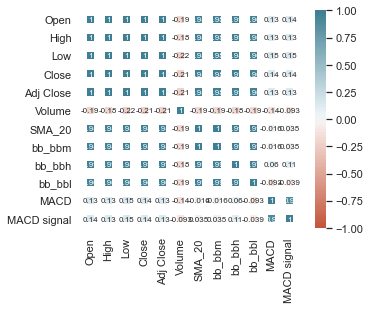

<Figure size 9000x9000 with 0 Axes>

In [13]:
corr_plot(MSFT)

# Using Random Forests for Microsoft Stock

In this test, I used Random Forests to forest prices for Microsoft's stock. It does a pretty good job of staying close to the actual prices compared to SVR.

Predicting values for the following dates: 
2019-12-24
2019-12-26
2019-12-27
2019-12-30
2019-12-31
Test Data Predicted Values: [156.7099719 156.7099719 155.9261126 156.7099719 156.2941073]
----------------------------------------------------------------------------------------------------
Actual Values: [156.951309 158.237793 158.527008 157.160736 157.270432]
----------------------------------------------------------------------------------------------------
Train Model Score: 1.0
----------------------------------------------------------------------------------------------------
Test Model Score: 1.0
----------------------------------------------------------------------------------------------------
Train Model R2 Score: 0.998228818198949
----------------------------------------------------------------------------------------------------
Test Model R2 Score: -4.197952611051045
----------------------------------------------------------------------------------------------------
Mean Squ

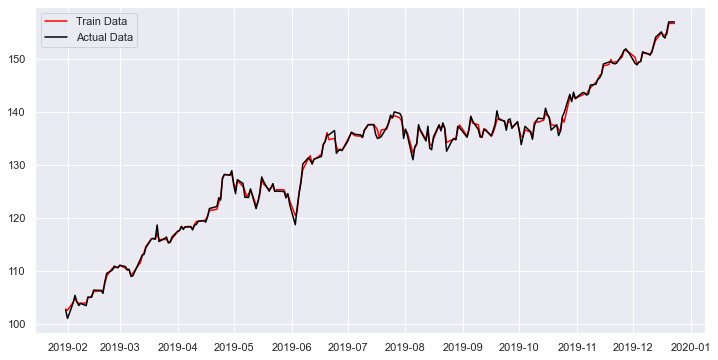

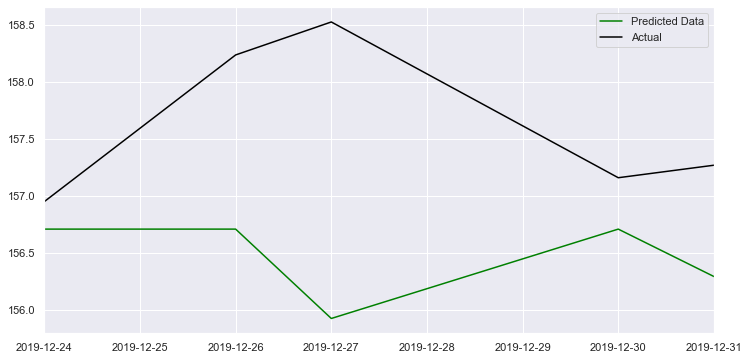

In [14]:
predict_using_random_forest(MSFT, MSFT_dates, num_forecast_days=5, estimators_user=10, max_depth=None)

# Using SVM (Regression) for Microsoft Stock

I next tried to leverage SVR (A component of SVM) to predict Microsoft's stock price. In my tuning, I found that using a C value for 1000 and a Gamma of .009 gave me the most reasonable results, but the predictions were quite off after day 1. Random Forests did a much better job overall. In addition, I was only able to use rbf, as linear and poly would cause my machine to run for an extremely long time. I ultimately had to stop and removing those two models from my testing.

Predicting values for the following dates: 
2019-12-24
2019-12-26
2019-12-27
2019-12-30
2019-12-31
Using user provided C 1000 and gamma 0.009 values
Predicted Values: [157.63060326 155.53830369 151.40569106 145.51812071 145.70659294]
----------------------------------------------------------------------------------------------------
Actual Values: [156.951309 158.237793 158.527008 157.160736 157.270432]
----------------------------------------------------------------------------------------------------
Model Score: 0.9981510843807295
----------------------------------------------------------------------------------------------------
Model R2 Score: -164.1760808755932
----------------------------------------------------------------------------------------------------
Mean Squared Error (MSE): 65.54694055220895
----------------------------------------------------------------------------------------------------
RMSE: 8.09610650573527


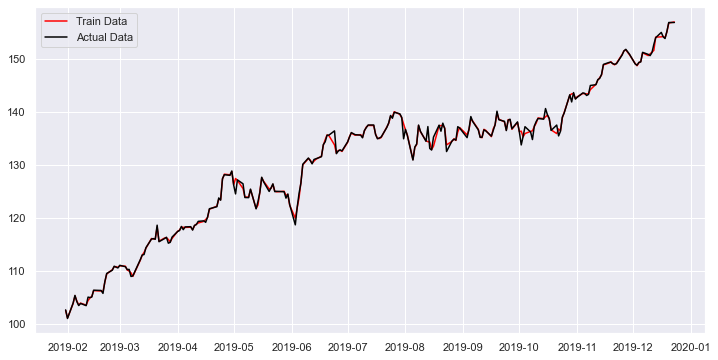

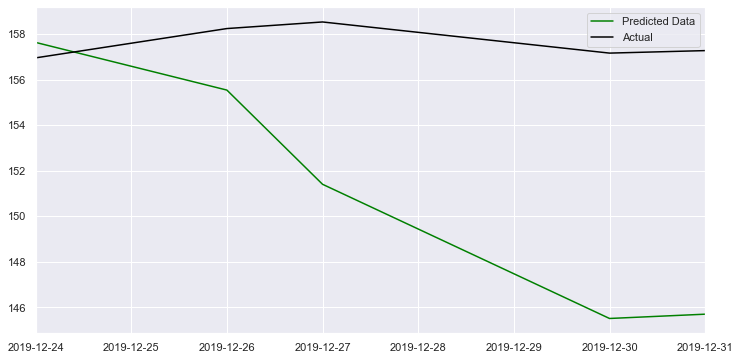

In [15]:
predict_multiple_variables(MSFT,MSFT_dates,num_forecast_days=5, C_user= 1000, G_user=.009, model = 'rbf')


# Predicting Apple Stock Prices

# Correlation Matrix based for Apple

The correlation matrix is printed below to show how much these values move together in the same/opposite direction

(12, 12)


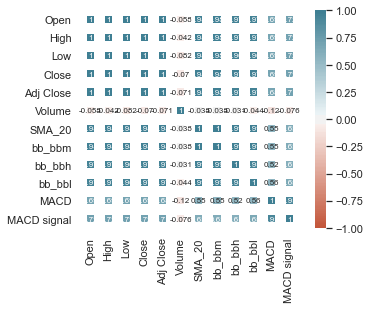

<Figure size 9000x9000 with 0 Axes>

In [16]:
corr_plot(AAPL)

# Using Random Forests for Apple Stock
In this test, I used Random Forests to forest prices for Apple. It did a decent job, but the predictions were relatively static. The model did not seem to handle the flucuations as well.

Predicting values for the following dates: 
2019-12-24
2019-12-26
2019-12-27
2019-12-30
2019-12-31
Test Data Predicted Values: [281.72498183 281.72498183 281.55618269 281.63399793 281.68367964]
----------------------------------------------------------------------------------------------------
Actual Values: [283.596924 289.223602 289.113831 290.829773 292.954712]
----------------------------------------------------------------------------------------------------
Train Model Score: 1.0
----------------------------------------------------------------------------------------------------
Test Model Score: 1.0
----------------------------------------------------------------------------------------------------
Train Model R2 Score: 0.9992358574173403
----------------------------------------------------------------------------------------------------
Test Model R2 Score: -5.822714999436348
----------------------------------------------------------------------------------------------------
Me

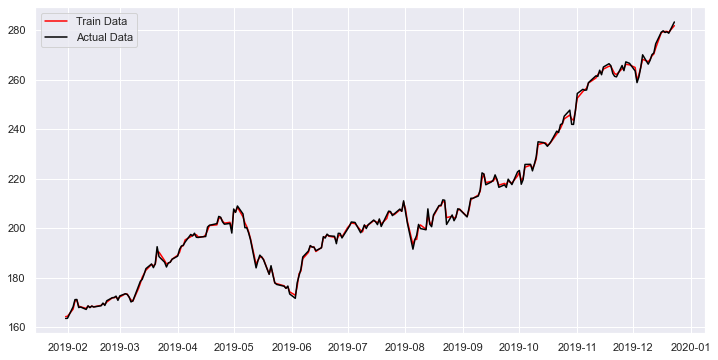

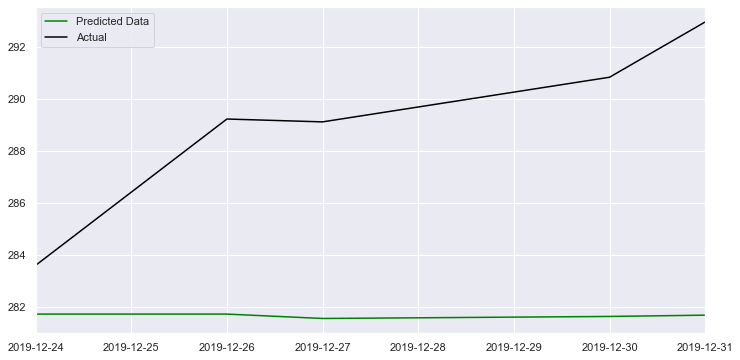

In [17]:
predict_using_random_forest(AAPL, AAPL_dates, num_forecast_days=5, estimators_user=100, max_depth=None)

# Using SVM (Regression) for Apple Stock

I next tried to leverage SVR (A component of SVM) to predict Apple's stock price. I chose to let GridSearch pick the best values and the predictions were much closer to the actual value two models from my testing.

Predicting values for the following dates: 
2019-12-24
2019-12-26
2019-12-27
2019-12-30
2019-12-31
Using Grid Search Values C 1000 and gamma 1e-05 values
Predicted Values: [283.95729543 284.4025591  288.96587974 288.30195148 288.75536972]
----------------------------------------------------------------------------------------------------
Actual Values: [283.596924 289.223602 289.113831 290.829773 292.954712]
----------------------------------------------------------------------------------------------------
Model Score: 0.9954768992163369
----------------------------------------------------------------------------------------------------
Model R2 Score: 0.014999505766224885
----------------------------------------------------------------------------------------------------
Mean Squared Error (MSE): 9.48371380990275
----------------------------------------------------------------------------------------------------
RMSE: 3.0795638993050214


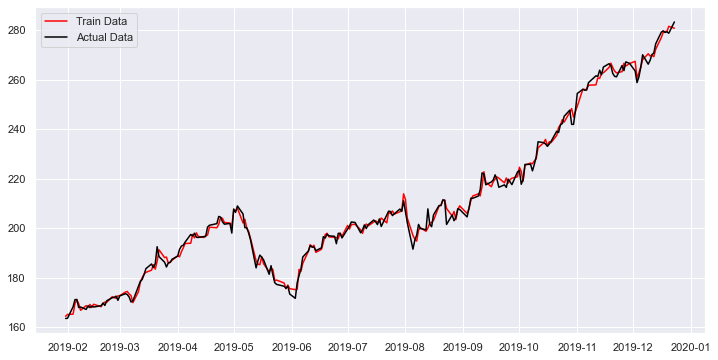

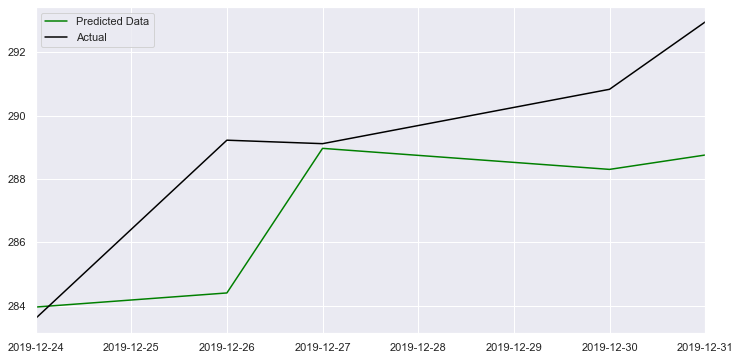

In [19]:
predict_multiple_variables(AAPL,AAPL_dates,num_forecast_days=5, model='rbf')


# Predicting Amazon Stock Prices

# Correlation Matrix based for Amazon

The correlation matrix is printed below to show how much these values move together in the same/opposite direction

(12, 12)


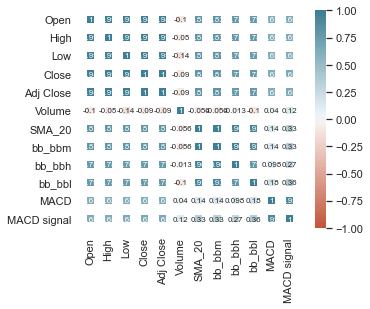

<Figure size 9000x9000 with 0 Axes>

In [20]:
corr_plot(AMZN)

# Using Random Forests for Amazon Stock

In this test, I used Random Forests to forest prices for Amazon. Random Forests captured the trend prettu well up until the final days. It miscalculated on a few days, but overall it was ok.

Predicting values for the following dates: 
2019-12-24
2019-12-26
2019-12-27
2019-12-30
2019-12-31
Test Data Predicted Values: [1781.95650258 1794.96479508 1879.14440535 1869.42250846 1834.47778828]
----------------------------------------------------------------------------------------------------
Actual Values: [1789.209961 1868.77002  1869.800049 1846.890015 1847.839966]
----------------------------------------------------------------------------------------------------
Train Model Score: 1.0
----------------------------------------------------------------------------------------------------
Test Model Score: 1.0
----------------------------------------------------------------------------------------------------
Train Model R2 Score: 0.9943257943125916
----------------------------------------------------------------------------------------------------
Test Model R2 Score: -0.4579195349025411
--------------------------------------------------------------------------------------------

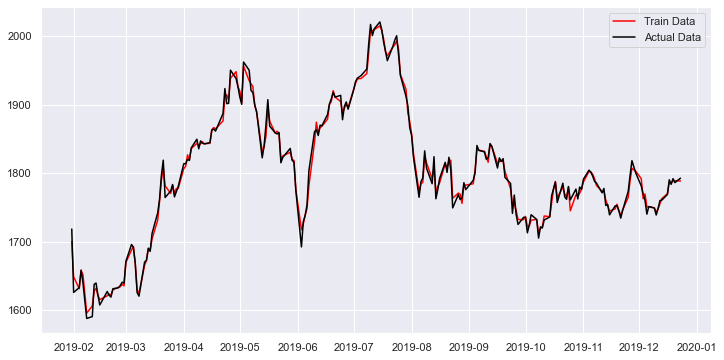

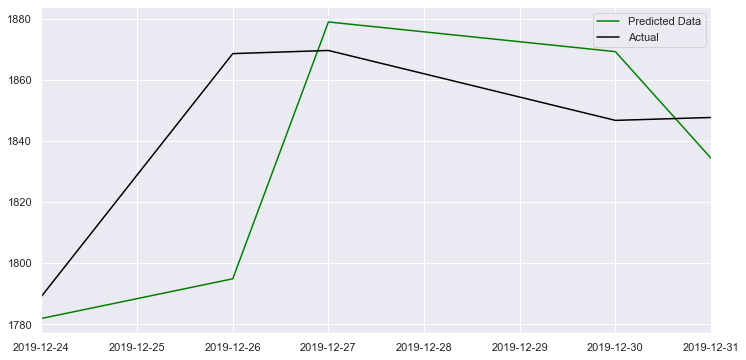

In [21]:
predict_using_random_forest(AMZN, AMZN_dates, num_forecast_days=5, estimators_user=100, max_depth=None)

# Using SVM (Regression) for Amazon 

I next tried to leverage SVR (A component of SVM) to predict Amazon's stock price. SVR did better at predicting the general trends (increase/decrease) vs Random Forests. The model score was 0.96, but looking at the graphs, the trends were generally the same vs Random Forests.

Predicting values for the following dates: 
2019-12-24
2019-12-26
2019-12-27
2019-12-30
2019-12-31
Using user provided C 1000 and gamma 1e-05 values
Predicted Values: [1781.96883403 1784.29741922 1848.5741245  1839.77444504 1812.48734658]
----------------------------------------------------------------------------------------------------
Actual Values: [1789.209961 1868.77002  1869.800049 1846.890015 1847.839966]
----------------------------------------------------------------------------------------------------
Model Score: 0.9683123540022426
----------------------------------------------------------------------------------------------------
Model R2 Score: -1.0774041145864826
----------------------------------------------------------------------------------------------------
Mean Squared Error (MSE): 1787.8066217515775
----------------------------------------------------------------------------------------------------
RMSE: 42.282462342578604


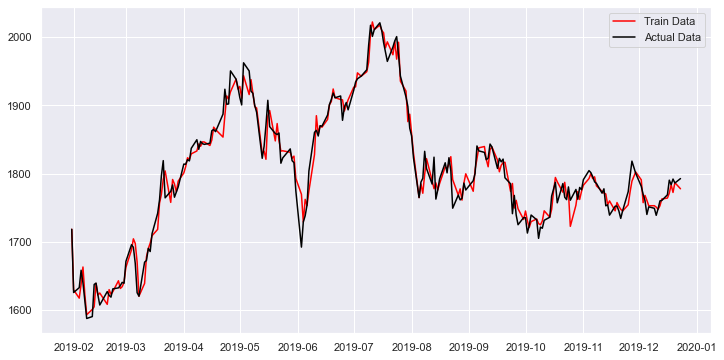

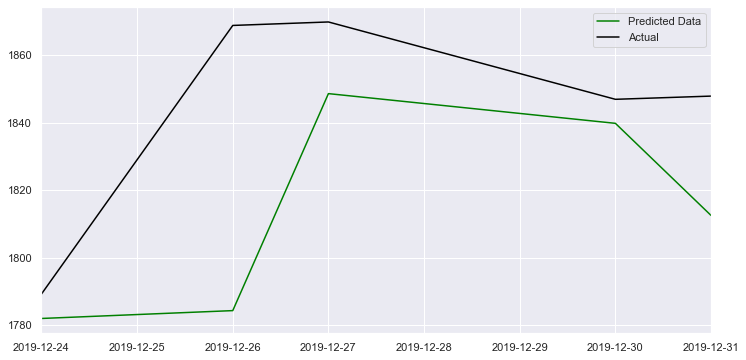

In [23]:
predict_multiple_variables(AMZN,AMZN_dates,num_forecast_days=5, C_user=1000, G_user=.00001)


# Predicting Google Stock Prices



# Correlation Matrix based for Google

The correlation matrix is printed below to show how much these values move together in the same/opposite direction

(12, 12)


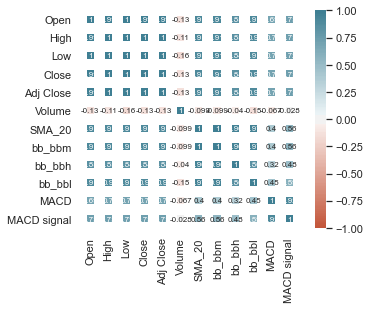

<Figure size 9000x9000 with 0 Axes>

In [24]:
corr_plot(GOOG)

# Using Random Forests for Google

Random forests for Google Stock seems to handle the predictions with a fairly stable price change. In testing, it appears that the price changes impacted how much Random Forests would shift the price up/down.

Predicting values for the following dates: 
2019-12-24
2019-12-26
2019-12-27
2019-12-30
2019-12-31
Test Data Predicted Values: [1349.12071854 1349.16971099 1349.72705557 1349.25568925 1342.53974768]
----------------------------------------------------------------------------------------------------
Actual Values: [1343.560059 1360.400024 1351.890015 1336.140015 1337.02002 ]
----------------------------------------------------------------------------------------------------
Train Model Score: 1.0
----------------------------------------------------------------------------------------------------
Test Model Score: 1.0
----------------------------------------------------------------------------------------------------
Train Model R2 Score: 0.9958471775679957
----------------------------------------------------------------------------------------------------
Test Model R2 Score: 0.144389183962492
----------------------------------------------------------------------------------------------

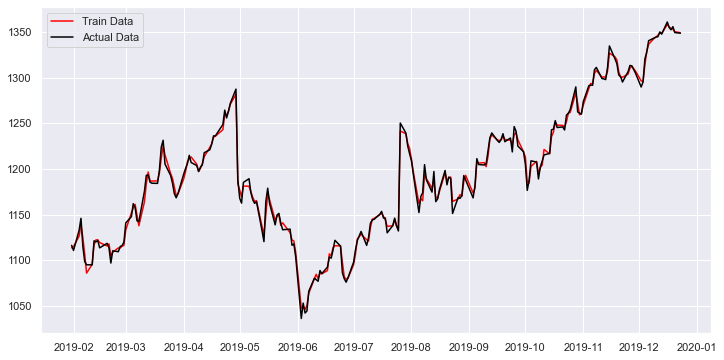

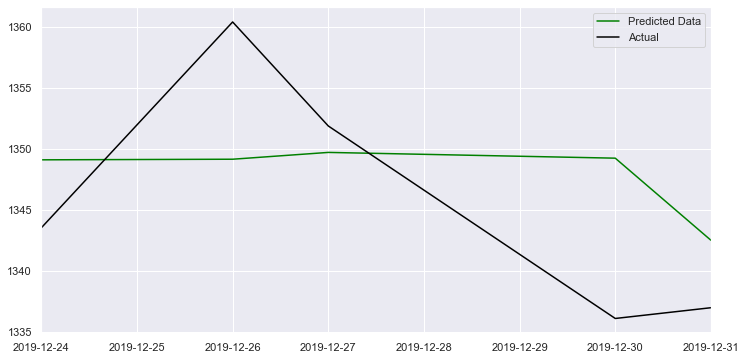

In [25]:
predict_using_random_forest(GOOG, GOOG_dates, num_forecast_days=5, estimators_user=1000, max_depth=None)

# Using SVM (Regression) for Google

SVM appears to capture the general trend (up/down) after day 1 fairly well. After that is fails or predict the price in the opposite direction as it does in day 1.

Predicting values for the following dates: 
2019-12-24
2019-12-26
2019-12-27
2019-12-30
2019-12-31
Using user provided C 1000 and gamma 0.0009 values
Predicted Values: [1338.98224563 1327.50971343 1309.32831451 1300.24275468 1243.46359312]
----------------------------------------------------------------------------------------------------
Actual Values: [1343.560059 1360.400024 1351.890015 1336.140015 1337.02002 ]
----------------------------------------------------------------------------------------------------
Model Score: 0.9937712999009238
----------------------------------------------------------------------------------------------------
Model R2 Score: -29.435915102093272
----------------------------------------------------------------------------------------------------
Mean Squared Error (MSE): 2591.129112350679
----------------------------------------------------------------------------------------------------
RMSE: 50.903134602406155


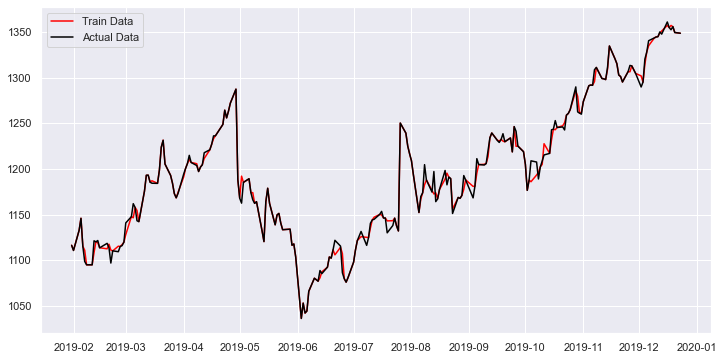

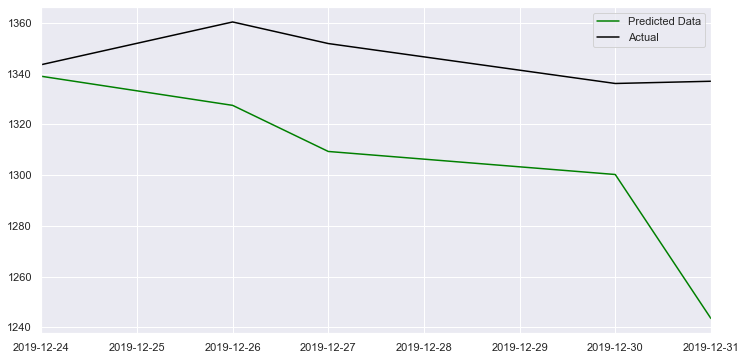

In [26]:
predict_multiple_variables(GOOG, GOOG_dates , num_forecast_days=5, C_user=1000, G_user=.0009,model =  'rbf')


# Predicting the S&P Index



# Predicting the S&P Index with Random Forests

Random Forests does overall better job of predicting the value long term, but SVR appears to capture the general trend much better.

Predicting values for the following dates: 
2019-12-24
2019-12-26
2019-12-27
2019-12-30
2019-12-31
Test Data Predicted Values: [3220.25898778 3218.17285784 3216.67173626 3219.86094384 3216.23705416]
----------------------------------------------------------------------------------------------------
Actual Values: [3223.379883 3239.909912 3240.02002  3221.290039 3230.780029]
----------------------------------------------------------------------------------------------------
Train Model Score: 1.0
----------------------------------------------------------------------------------------------------
Test Model Score: 1.0
----------------------------------------------------------------------------------------------------
Train Model R2 Score: 0.9963810910837241
----------------------------------------------------------------------------------------------------
Test Model R2 Score: -2.963134855757955
---------------------------------------------------------------------------------------------

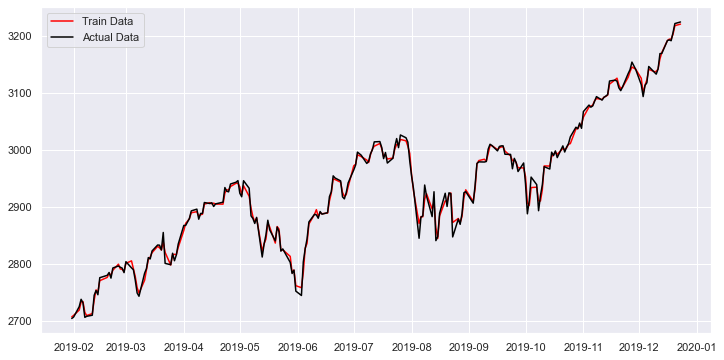

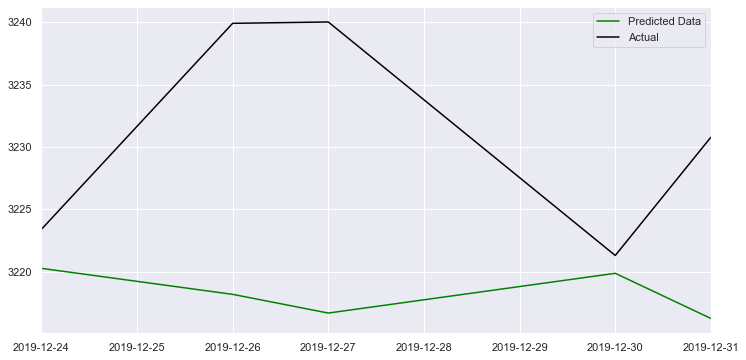

In [27]:
predict_using_random_forest(_GSPC, _GSPC_dates, num_forecast_days=5, estimators_user=1000, max_depth=None)

# Predicting the S&P Index with SVM (SVR)

SVR appears to capture the general trend of the S&P much better than Random Forests. The price gap, however, appears to diverge significantly after day 3 vs Random Forests. So while SVR captures the trend better, Random Forests stays closer to the actual prices during predictions.

Predicting values for the following dates: 
2019-12-24
2019-12-26
2019-12-27
2019-12-30
2019-12-31
Using user provided C 1000 and gamma 9e-05 values
Predicted Values: [3226.08732171 3226.15327491 3215.55131216 3218.79033614 3220.12542198]
----------------------------------------------------------------------------------------------------
Actual Values: [3223.379883 3239.909912 3240.02002  3221.290039 3230.780029]
----------------------------------------------------------------------------------------------------
Model Score: 0.9861616259107151
----------------------------------------------------------------------------------------------------
Model R2 Score: -1.922434860331256
----------------------------------------------------------------------------------------------------
Mean Squared Error (MSE): 183.0124234498263
----------------------------------------------------------------------------------------------------
RMSE: 13.528208434594223


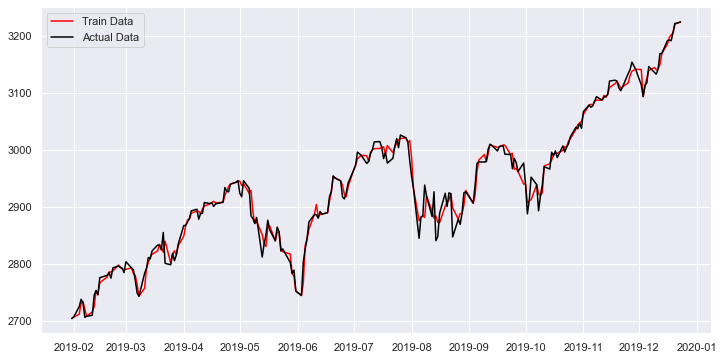

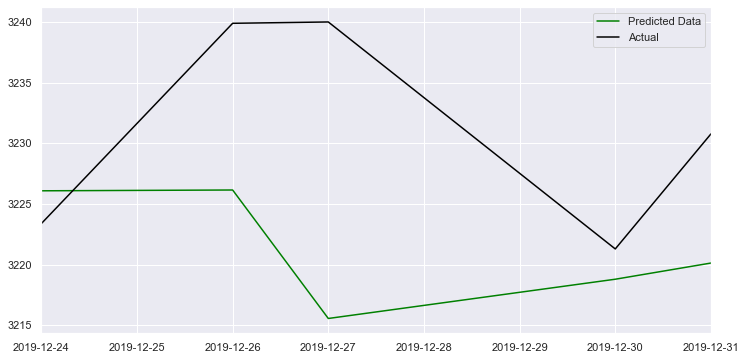

In [28]:
predict_multiple_variables(_GSPC, _GSPC_dates, num_forecast_days=5, C_user=1000, G_user=.00009,model =  'rbf')